In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer
from sklearn.metrics import make_scorer
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split,  cross_validate
from sklearn.preprocessing import StandardScaler
import time
import sys, os
from sklearn.pipeline import make_pipeline


path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")





INPUT DATA

In [23]:
X = (df.iloc[:,14:]).values
print(X.shape)
std_scaler = StandardScaler()

(2905, 530)


OUTPUT DATA

In [24]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


**NRMSEPiqr**

In [25]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


PLS NRMSEPiqr

In [30]:
from sklearn_genetic.callbacks import ProgressBar
callback = ProgressBar()

np.random.seed(42)
    
    
ripartisions = [0.25, 0.50, 0.75]
for ripartition in ripartisions:
        
            NRMSEP = []
            best_value= 100000000
            best_n = 0

            

            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42)
            param_grid = {'n_components': Integer(2,530,random_state=42),'max_iter': Integer(100, 500)}
            pls =  PLSRegression()
            
            sturges = int(1 + np.log(len(X_train)))    
                
            evolved_estimator = GASearchCV(estimator=pls,
                              cv=sturges,
                              scoring=NRMSEPiqrscorer,
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=True,
                              population_size=50,
                              generations=50,
                              criteria = "min")  
            
            evolved_estimator.fit(X_train, Y_train,callbacks=callback)
    
            print("Best value of n_components: ", str(evolved_estimator.best_params_["n_components"]))



  0%|          | 0/51 [00:00<?, ?it/s]

PLS NRMSEPiqr 57 components

57 components


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished


╔════════════════╦═════════════════════╦═════════════════════╦═══════════════════════════════╦═════════════════════════════╦═══════════════════╗
║   Test size(%) ║   Mean CV NRMSEPiqr ║   Var CV NRMSEPiqr) ║   Mean CV Training Time (sec) ║   Final training time (sec) ║   Final NRMSEPiqr ║
╠════════════════╬═════════════════════╬═════════════════════╬═══════════════════════════════╬═════════════════════════════╬═══════════════════╣
║             25 ║            0.292015 ║         0.000523498 ║                      1.48238  ║                    0.631835 ║          0.332325 ║
║             50 ║            0.300209 ║         0.000642236 ║                      0.799608 ║                    0.340007 ║          0.307921 ║
║             75 ║            0.357018 ║         0.00261721  ║                      0.142379 ║                    0.712625 ║          0.337952 ║
╚════════════════╩═════════════════════╩═════════════════════╩═══════════════════════════════╩═════════════════════════════╩══════

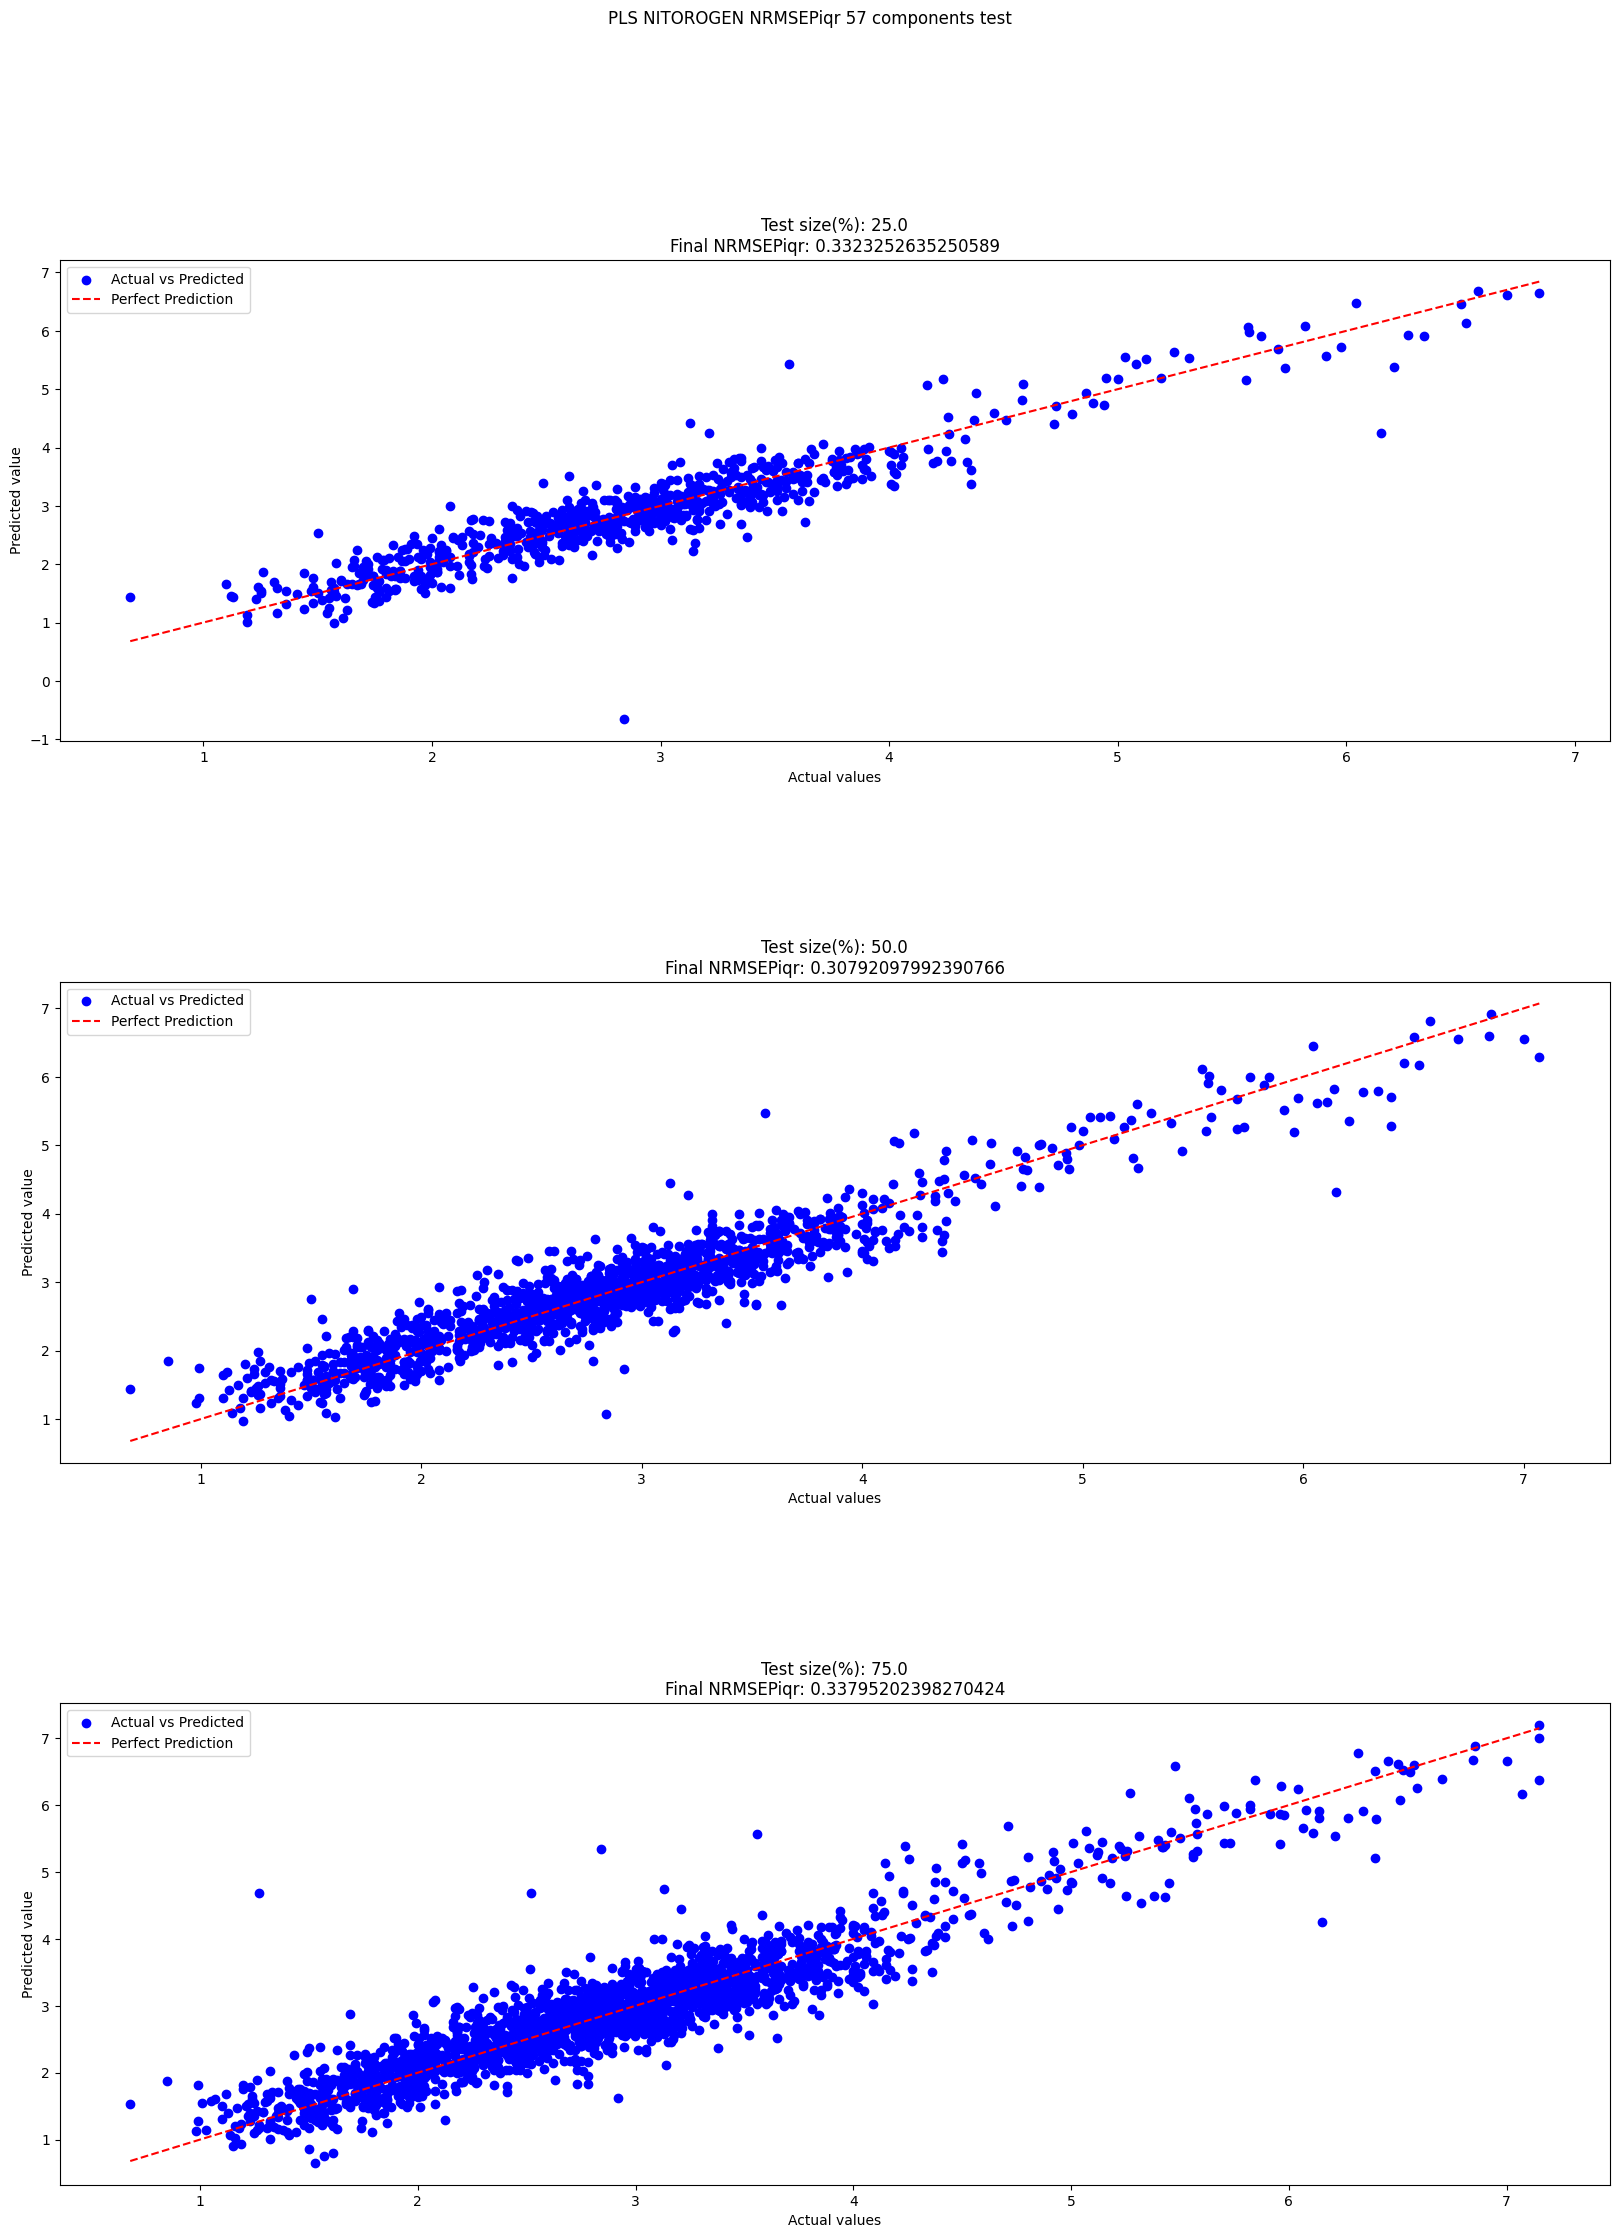

In [26]:

n_components = 57


results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('PLS NITOROGEN NRMSEPiqr 57 components test' + "\n")
axs = axs.flatten()
k = 0

np.random.seed(42)

    

results = []  
ripartisions = [0.25, 0.50, 0.75]
print(str(n_components) + " components" )
for ripartition in ripartisions:

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42)
    X_train= std_scaler.fit_transform(X_train)
    X_test= std_scaler.transform(X_test)
    pls_model = PLSRegression(n_components=n_components)
        
    start_time = time.time()
    pls_model.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds
       
    # Make predictions using the testing set
    Y_pred_pls = pls_model.predict(X_test)

    sturges = int(1 + np.log(len(X_train)))    
    cv_scores = cross_validate(pls_model, X_train, Y_train, cv=sturges, scoring=NRMSEPiqrscorer,n_jobs=-1, verbose=1)      

    results.append([str(ripartition *100 ),-np.mean(cv_scores['test_score']), np.var(cv_scores['test_score']),
                    np.mean(cv_scores['fit_time']), elapsed_time, NRMSEPiqr(Y_test, Y_pred_pls) ])


    '''PLOT THE BEST MODELS'''
    axs[k].scatter(Y_test,Y_pred_pls, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                        [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "Final NRMSEPiqr: " + str(results[k][5]) )
    k += 1

'''SHOW RESULTS'''

headers = ["Test size(%)", "Mean CV NRMSEPiqr", "Var CV NRMSEPiqr)","Mean CV Training Time (sec)" ,"Final training time (sec)","Final NRMSEPiqr"]
print(tabulate(results, headers,  tablefmt="double_outline"))


In [29]:
# Extract latent variables (scores)
X_latent = pls_model.x_scores_  # Latent variables for predictors
Y_latent = pls_model.y_scores_  # Latent variables for target

print(X_latent.shape)  # Should output (726, n_components)
print(Y_latent.shape)  # Should output (726, 1) if it's a single target variable

# Convert to DataFrames for easier inspection
X_latent_df = pd.DataFrame(X_latent, columns=[f'Latent Variable {i+1}' for i in range(n_components)])
Y_latent_df = pd.DataFrame(Y_latent, columns=['Latent Variable Y'])

# Display the latent variables
print("Latent Variables for X:\n", X_latent_df.head())
print("Latent Variables for Y:\n", Y_latent_df.head())

AttributeError: 'PLSRegression' object has no attribute 'Y_scores_'